(200, 200)


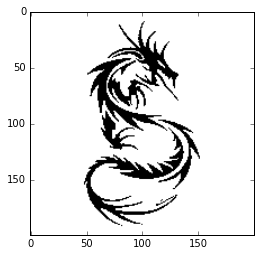

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import colorsys
from PIL import Image

img = Image.open('dragon_200.png')
img = img.convert('RGB')

print(img.size)
plt.imshow(img)


In [12]:
TILE_SIZE = 10 # Size of the tile => 10x10
BITS = 1       # Color depth

class Tile:
    def get_pixel(self, row, col):
        return self.pixels[row][col]
    
    def to_binary(self):
        if (BITS == 8):
            binary = [bin(x)[2:].zfill(8) for x in self.pixels.flatten()]
            return np.array([list(map(int, x)) for x in binary]).flatten()
        if (BITS == 1):
            binary = []
            for x in self.pixels.flatten():
                assert(x == 255 or x == 0)
                binary.append(x // 255)
            return np.array(binary)
    
    def __init__(self, pixels):
        self.pixels = pixels
        
def tile_equals(tile1, tile2):
    return np.array_equal(tile1.pixels.flatten(), tile2.pixels.flatten())


In [13]:
WIDTH = img.size[0]
HEIGHT = img.size[1]

WIDTH_TILES = WIDTH // TILE_SIZE
HEIGHT_TILES = HEIGHT // TILE_SIZE

def get_tiles_from_img(img):
    img_data = np.array(img.getdata()).reshape(WIDTH, HEIGHT, 3) 
    print("Img data shape: ", img_data.shape)
    
    tiles = []
    for row in range(HEIGHT_TILES):
        for col in range(WIDTH_TILES):
            
            pixels = []
            count = 0
            for offset_row in range(TILE_SIZE):
                for offset_col in range(TILE_SIZE):
                    pixels.append(img_data[row * TILE_SIZE + offset_row][col * TILE_SIZE + offset_col])
                
            tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    
    return np.array(tiles)

In [14]:
def show_tiles(tiles):
    reshaped_tiles = tiles.reshape(WIDTH_TILES, HEIGHT_TILES)
    pixels = np.empty([WIDTH, HEIGHT, 3])
    for row in range(HEIGHT_TILES):
        for col in range(WIDTH_TILES):
            for offset_row in range(TILE_SIZE):
                for offset_col in range(TILE_SIZE):
                    tile = reshaped_tiles[row][col]
                    pixels[row * TILE_SIZE + offset_row][col * TILE_SIZE + offset_col] = tile.get_pixel(offset_row, offset_col)
    im = Image.fromarray(np.uint8(pixels))
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original')
    
    plt.subplot(1,2,2)
    plt.imshow(im)
    plt.title('Predicted')
    
def to_color_depth_8(binary):
    r = binary[0:BITS]
    g = binary[BITS:2*BITS]
    b = binary[2*BITS:3*BITS]

    if (BITS == 1):
        if ((r + g + b)[0] >= 2):
            return [255, 255, 255]
        else:
            return [0, 0, 0]
        
    if (BITS == 8):
        result = []
        for color in [r, g, b]:
            binar = map(str, color)
            result.append(int(''.join(binar), 2))
        return result

def predicted_to_tiles(predicted):
    tiles = []
    for pred in predicted:
        reshaped = pred.reshape(TILE_SIZE * TILE_SIZE, 3, BITS)
        pixels = [to_color_depth_8(x.flatten()) for x in reshaped]
        tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    return np.array(tiles)

In [15]:
assert(WIDTH % TILE_SIZE == 0 and HEIGHT % TILE_SIZE == 0)

In [16]:
tiles = get_tiles_from_img(img)

train_x = [t.to_binary() for t in tiles]
train_y = np.copy(train_x)

Img data shape:  (200, 200, 3)


In [17]:
from scipy import misc
HIDDEN_1 = 4
HIDDEN_2 = 8
throughput = 0
for i in range(HIDDEN_1 + 1):
    throughput += misc.comb(HIDDEN_2, i, exact=1)
print("Max throughput (between two hidden layers): ", throughput)

Max throughput (between two hidden layers):  163


C:\Anaconda2\envs\py3k\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Model score (train data):  0.665


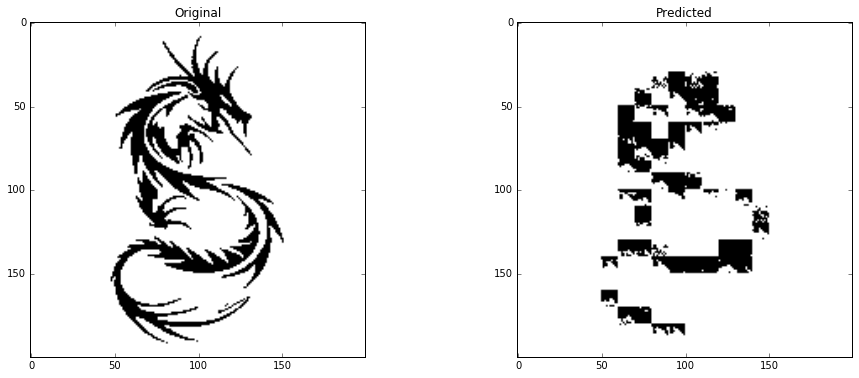

In [21]:
from sklearn import neural_network as nn
clf = nn.MLPClassifier(hidden_layer_sizes=(HIDDEN_1, HIDDEN_2),
                       activation='relu',
                       solver='adam',
                       alpha=0.0001,
                       shuffle=True,
                       verbose=False,
                       warm_start=False,
                       tol=0.00001,
                       max_iter=500,
                       learning_rate='constant',
                       learning_rate_init=0.001)

model = clf.fit(train_x, train_y)
print("Model score (train data): ", model.score(train_x, train_y))

predicted = model.predict(train_x)
tiles = predicted_to_tiles(predicted)

show_tiles(tiles)

Types of tiles used:  43


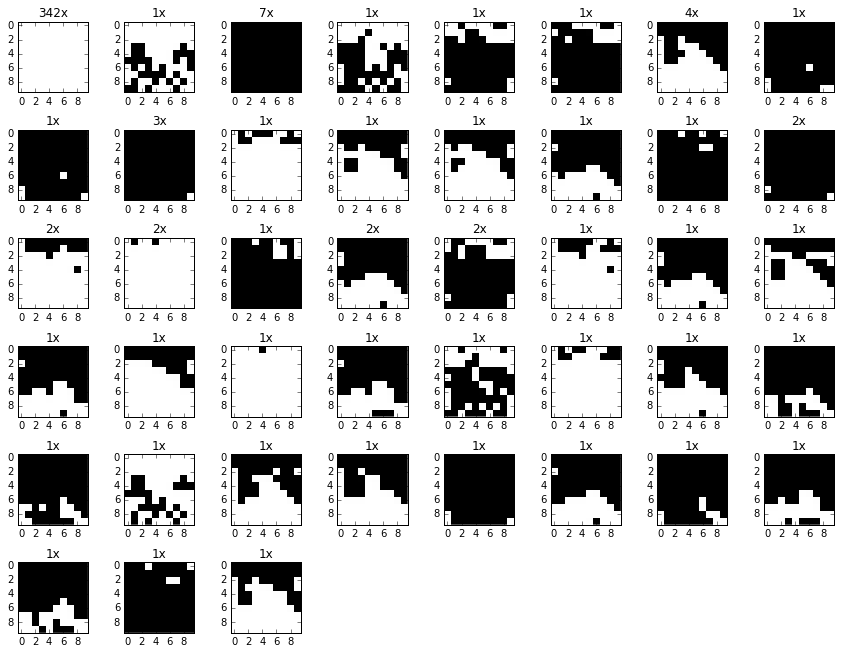

In [22]:
unique_tiles = []

for t in tiles:
    used_tile = False
    for u in unique_tiles:
        if tile_equals(t, u):
            used_tile = True
            break
    if not used_tile:
        unique_tiles.append(t)

print("Types of tiles used: ", len(unique_tiles))

tile_counts = np.array([0] * len(unique_tiles))
for i in range(len(tile_counts)):
    for t in tiles:
        if (tile_equals(t, unique_tiles[i])):
            tile_counts[i] += 1

plt.figure(figsize=(12, 30))
for i in range(1, len(unique_tiles) + 1):
    im = Image.fromarray(np.uint8(unique_tiles[i-1].pixels))
    plt.subplot(20,8,i)
    title = "{}x".format(tile_counts[i-1])
    plt.title(title)
    plt.imshow(im, interpolation='none')
    
plt.tight_layout()

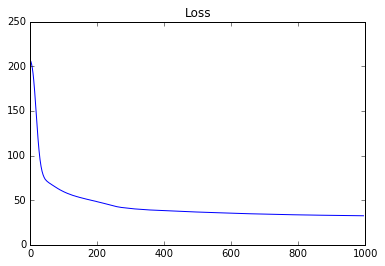

In [20]:
plt.plot(model.loss_curve_)
plt.title('Loss')

## Throughput
Throughput of the network at the point where the network extends (layer i -> j): 

$ n = \text{size of j (bigger layer)  } k = \text{size of i (smaller layer)} $

$$ \sum_{i=0}^{k} {n \choose i} $$
